## Script de Clasificación Cuántica vs Clásica en Física de Altas Energías (HEP)

**Dataset:** SUSY (Supersymmetry) del UCI Machine Learning Repository  
**Objetivo:** Clasificación de eventos para identificar la generación de partículas supersimétricas (signal) o partículas del modelo estándar (background).


In [1]:
# ============================================================================
# 0. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN
# ============================================================================

import numpy as np
import pandas as pd
import gzip
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

# Qiskit (versión moderna)
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, RealAmplitudes, PauliFeatureMap
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableKernel
from qiskit_aer import AerSimulator

# Semilla global
algorithm_globals.random_seed = 42
np.random.seed(42)

In [2]:
# ============================================================================
# 0.1. VERIFICACIÓN DE VERSIONES
# ============================================================================

import qiskit
import qiskit_machine_learning
import qiskit_algorithms
import sklearn

print("Versión de qiskit:", qiskit.__version__)
print("Versión de qiskit-machine-learning:", qiskit_machine_learning.__version__)
print("Versión de qiskit-algorithms:", qiskit_algorithms.__version__)
print("Versión de scikit-learn:", sklearn.__version__)
print("Versión de numpy:", np.__version__)
print("Versión de pandas:", pd.__version__)

Versión de qiskit: 1.2.4
Versión de qiskit-machine-learning: 0.7.2
Versión de qiskit-algorithms: 0.3.0
Versión de scikit-learn: 1.5.2
Versión de numpy: 1.26.4
Versión de pandas: 2.2.2


In [3]:
# ============================================================================
# 1. CARGA Y PREPARACIÓN INICIAL DE DATOS (SUSY)
# ============================================================================

# Ruta del archivo SUSY completo (50k eventos)
file_path = r'C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\Computación Cuántica - INF465\susy\SUSY.csv.gz'

# Nombres de columnas (adaptado a tu notación)
column_names = [
    'label',
    'lepton1_pT', 'lepton1_eta', 'lepton1_phi',
    'lepton2_pT', 'lepton2_eta', 'lepton2_phi',
    'missing_energy_magnitude', 'missing_energy_phi',
    'MET_rel', 'axial_MET', 'M_R', 'M_TR_2', 'R',
    'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos_theta_r1'
]

# Número de filas a cargar (similar a Terashi pero más grande)
N_ROWS_TO_LOAD = 50000

df = pd.read_csv(
    file_path,
    compression='gzip',
    names=column_names,
    nrows=N_ROWS_TO_LOAD
)

print(f"Dataset cargado exitosamente: {df.shape[0]} muestras, {df.shape[1]-1} características")
print(f"  - Señal (label=1): {(df['label']==1).sum()} muestras")
print(f"  - Fondo (label=0): {(df['label']==0).sum()} muestras")

df.head()

Dataset cargado exitosamente: 50000 muestras, 18 características
  - Señal (label=1): 23008 muestras
  - Fondo (label=0): 26992 muestras


,label,lepton1_pT,lepton1_eta,lepton1_phi,lepton2_pT,lepton2_eta,lepton2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


| Variable                   | Descripción                                                                                   |
|----------------------------|----------------------------------------------------------------------------------------------|
| `label`                    | Etiqueta de clase: 1 = Evento señal (SUSY), 0 = Evento fondo (Standard Model)                |
| `lepton1_pT`               | Momento transversal del primer leptón                                                         |
| `lepton1_eta`              | Pseudorapidez del primer leptón                                                              |
| `lepton1_phi`              | Ángulo azimutal del primer leptón                                                            |
| `lepton2_pT`               | Momento transversal del segundo leptón                                                       |
| `lepton2_eta`              | Pseudorapidez del segundo leptón                                                             |
| `lepton2_phi`              | Ángulo azimutal del segundo leptón                                                           |
| `missing_energy_magnitude` | Magnitud de la energía faltante (MET, Missing Transverse Energy)                             |
| `missing_energy_phi`       | Ángulo azimutal de la energía faltante                                                       |
| `MET_rel`                  | Energía transversal faltante relativa                                                        |
| `axial_MET`                | Componente axial de la energía faltante                                                      |
| `M_R`                      | Variable de masa relacionada con la reconstrucción de eventos                                |
| `M_TR_2`                   | Variable de masa transversal (versión 2)                                                     |
| `R`                        | Variable de razón utilizada en la discriminación de eventos                                  |
| `MT2`                      | Variable de masa transversal para dos partículas                                             |
| `S_R`                      | Variable relacionada con la suma de razones                                                  |
| `M_Delta_R`                | Diferencia de masa en función de la distancia en el espacio de parámetros                    |
| `dPhi_r_b`                 | Diferencia de ángulo azimutal entre objetos relevantes                                      |
| `cos_theta_r1`             | Coseno del ángulo polar de uno de los objetos reconstruidos                                 |

> **Nota:** Todas las variables corresponden a características físicas extraídas de eventos simulados en colisionadores, utilizadas para distinguir entre procesos estándar y supersimétricos.

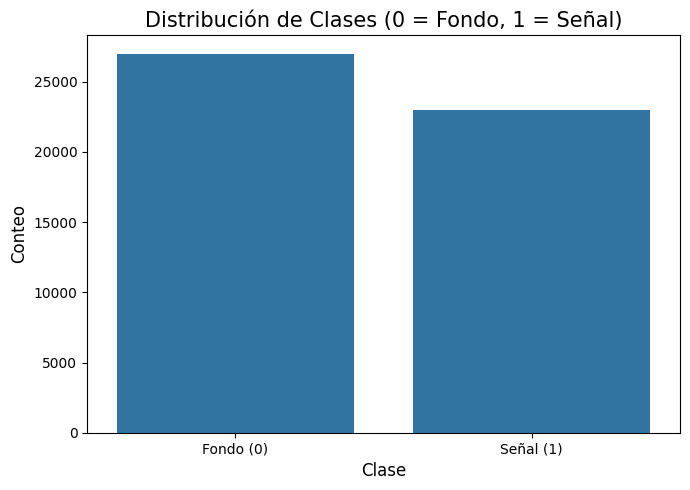

In [4]:
# ============================================================================
# 1.1. ANÁLISIS EXPLORATORIO BÁSICO
# ============================================================================

plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=df)
plt.title('Distribución de Clases (0 = Fondo, 1 = Señal)', fontsize=15)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Conteo', fontsize=12)
plt.xticks([0, 1], ['Fondo (0)', 'Señal (1)'])
plt.tight_layout()
plt.show()

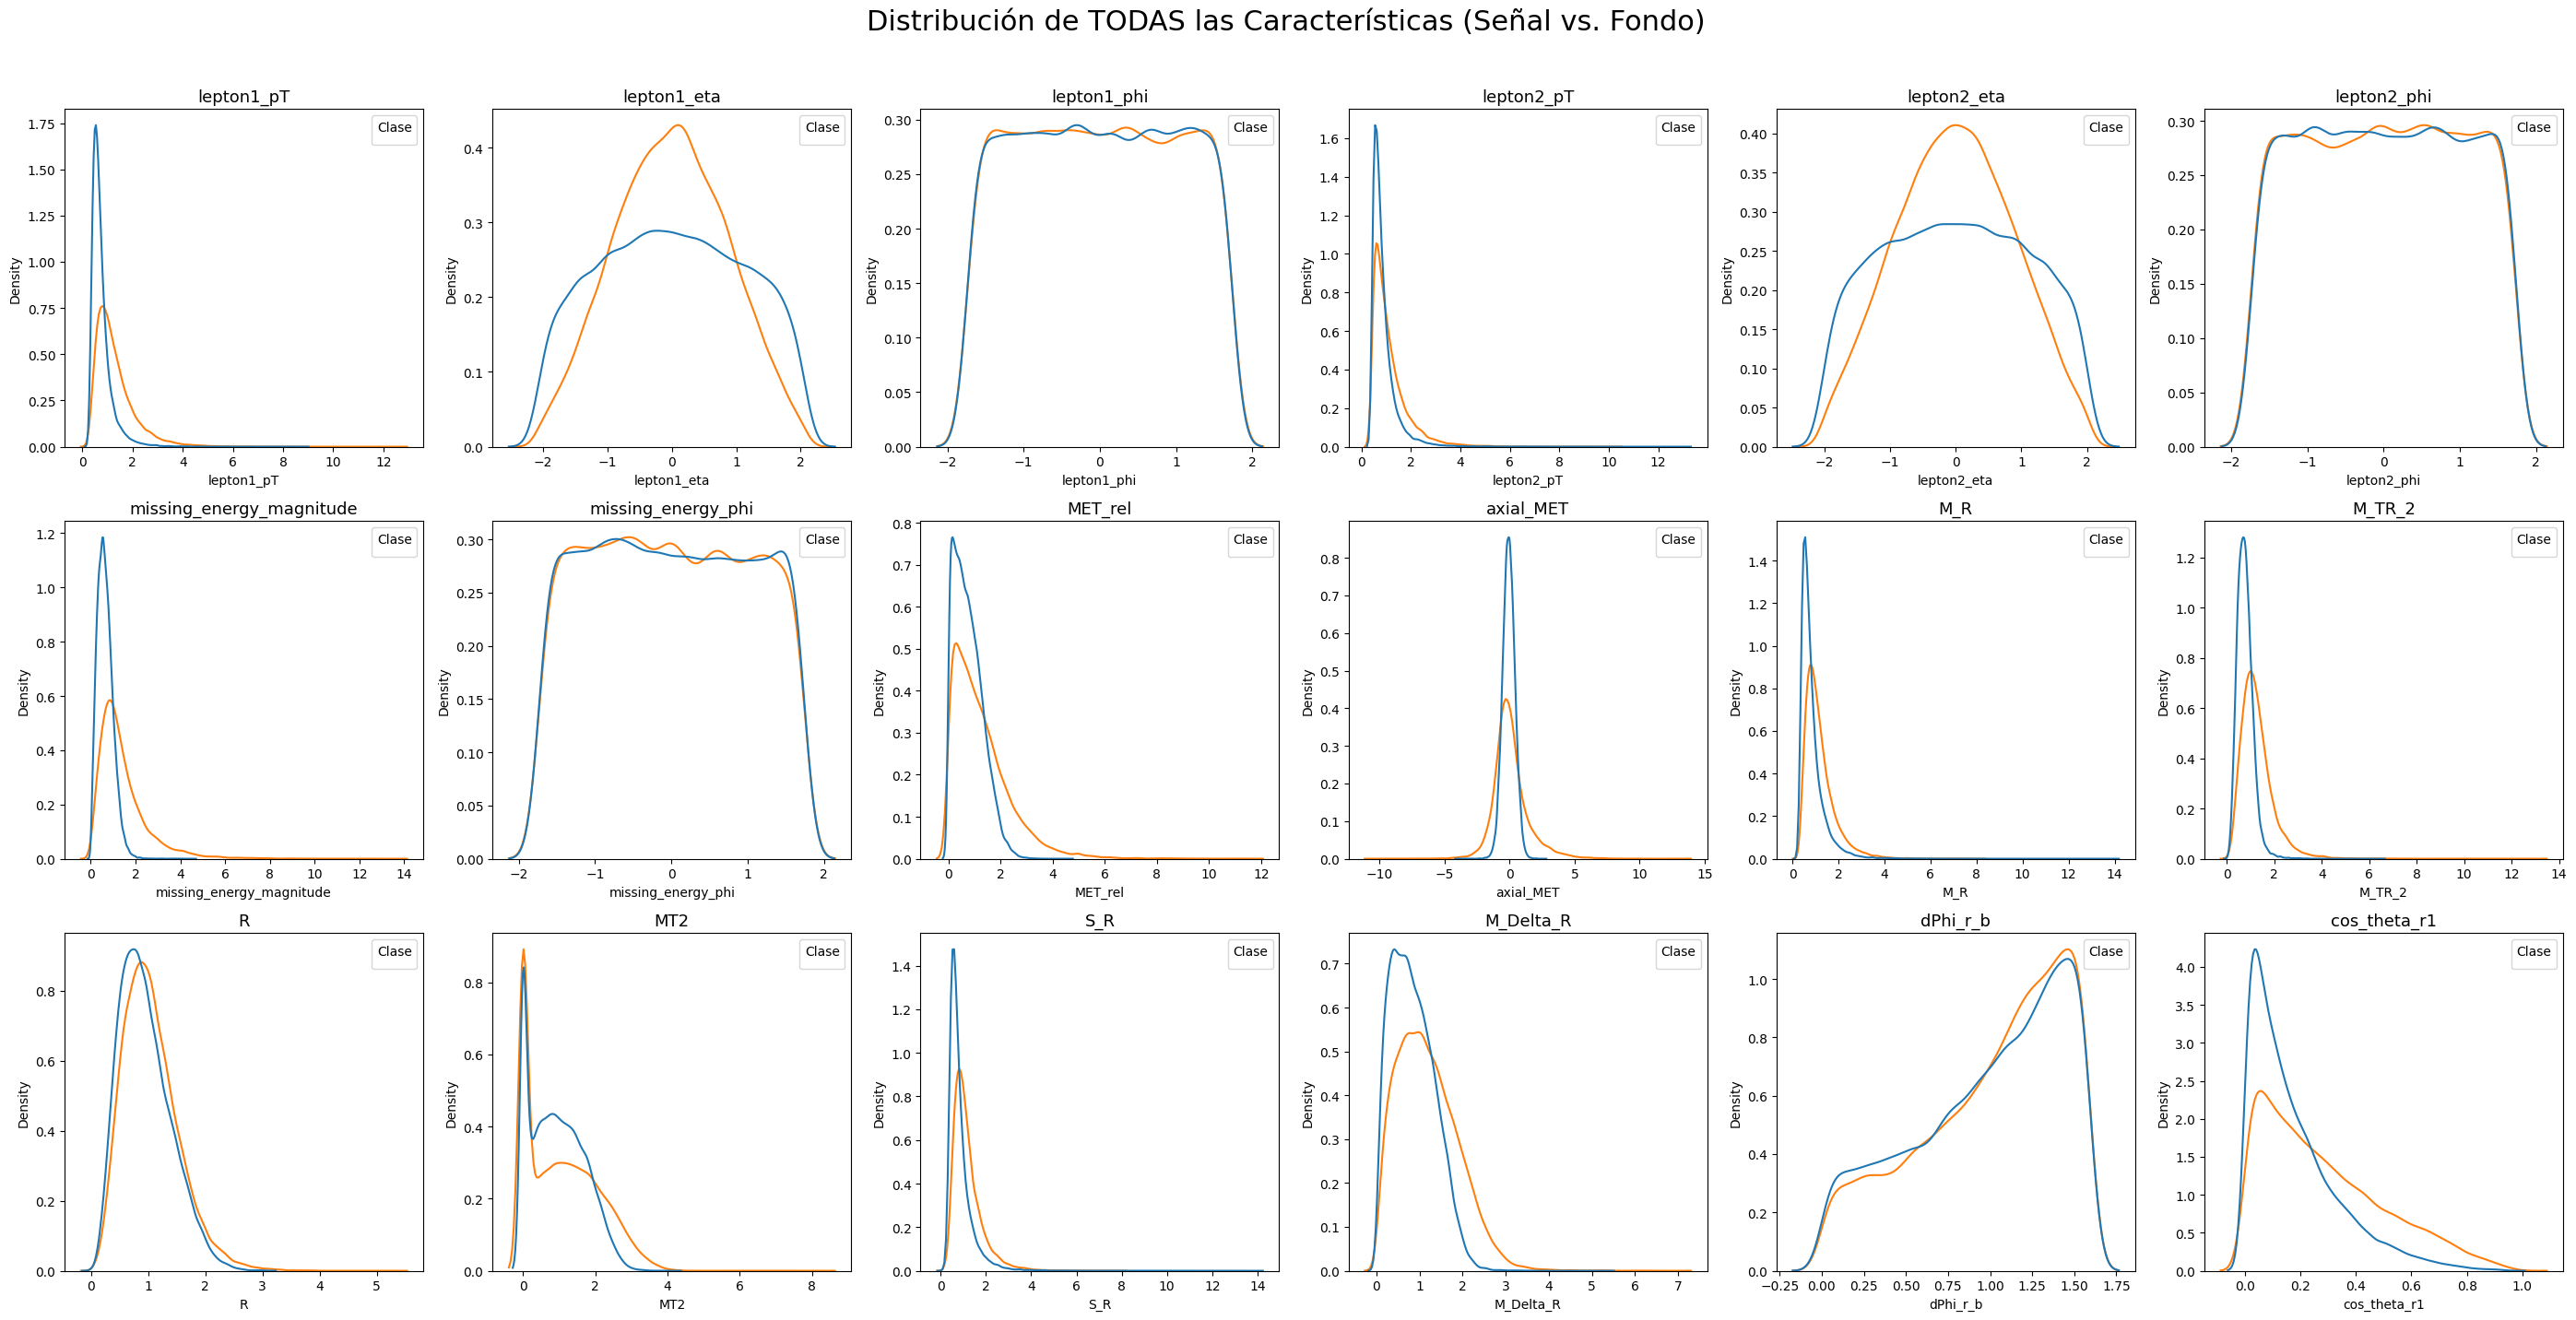

In [5]:
all_features = df.columns.drop('label')
fig, axes = plt.subplots(3, 6, figsize=(28, 14))
fig.suptitle('Distribución de TODAS las Características (Señal vs. Fondo)', fontsize=22, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(all_features):
    sns.kdeplot(data=df, x=feature, hue='label', ax=axes[i], common_norm=False)
    axes[i].set_title(f'{feature}', fontsize=13)
    legend = axes[i].get_legend()
    if legend is not None:
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend(handles, ['Señal (1)', 'Fondo (0)'], title='Clase')
    else:
        # No leyenda, no hacer nada
        pass

# Oculta los ejes vacíos si hay menos de 18 features
for j in range(len(all_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('feature_kde_all.png')

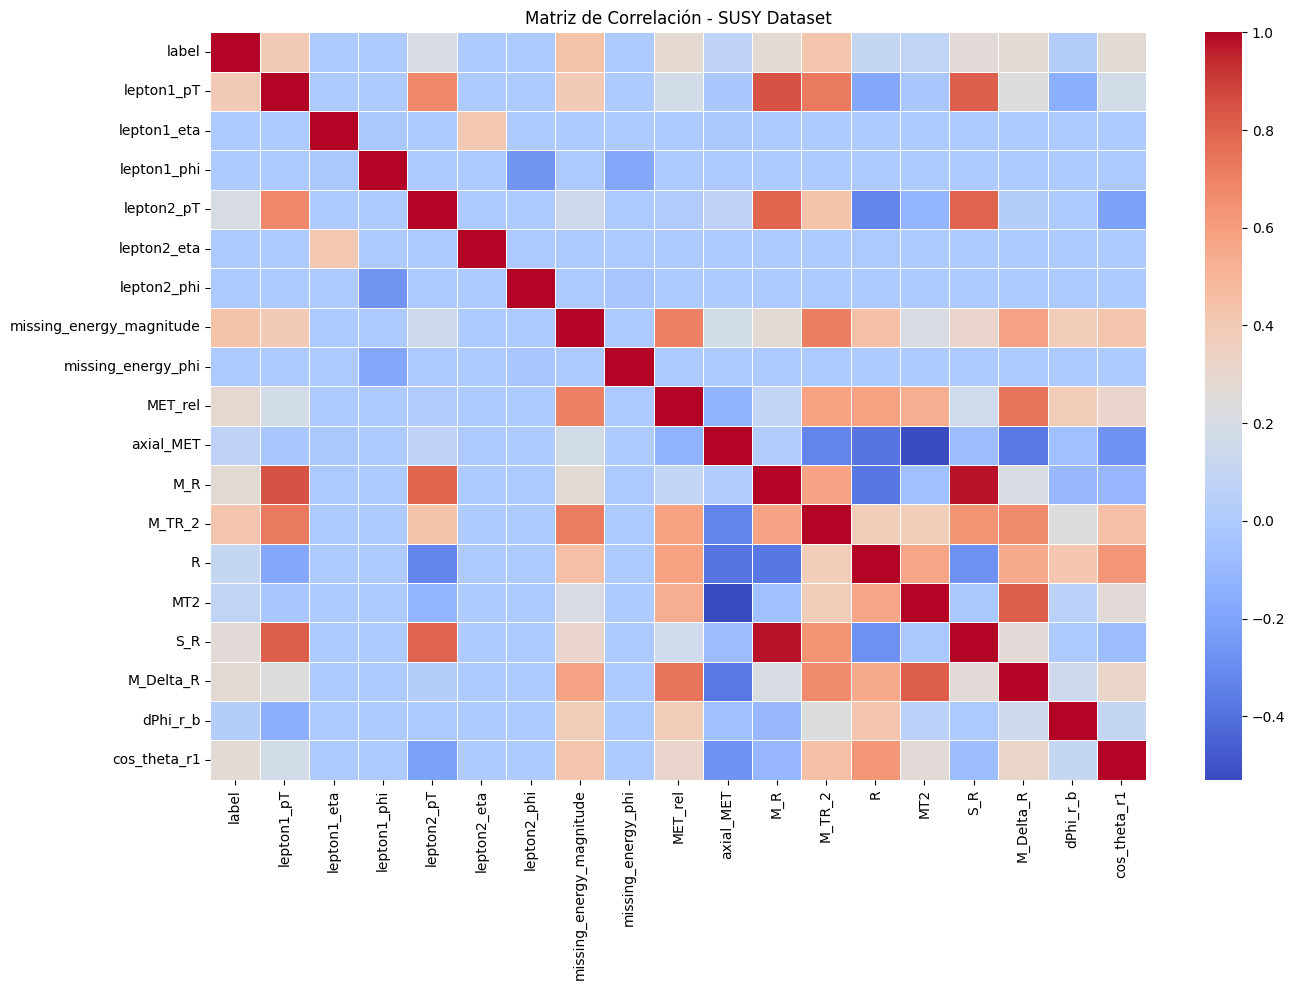

In [6]:
# Matriz de correlación
corr_matrix = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación - SUSY Dataset")
plt.tight_layout()
plt.show()

In [7]:
# Correlación de cada variable con la etiqueta
corr_label = corr_matrix['label'].drop('label').abs().sort_values(ascending=False)

tabla_corr_completa = pd.DataFrame({
    'Variable': corr_label.index,
    'Correlación absoluta con label': corr_label.values
})

display(tabla_corr_completa)

,Variable,Correlación absoluta con label
0,missing_energy_magnitude,0.436775
1,M_TR_2,0.422959
2,lepton1_pT,0.394117
3,MET_rel,0.283381
4,M_Delta_R,0.273180
5,M_R,0.272100
6,cos_theta_r1,0.268426
7,S_R,0.262015
8,lepton2_pT,0.200238
9,R,0.107778


In [8]:
# ============================================================================
# 2. SELECCIÓN DE FEATURES MEJORADA (Basada en Correlación)
# ============================================================================

# Opción 1: Selección manual de las top features correlacionadas
# Basado en tu análisis de correlación, usar las más discriminativas
#selected_features = ['axial_MET', 'MET_rel', 'missing_energy_magnitude', 'M_R']

# Opción 2: Selección automática de top N features
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=3)
X_temp = selector.fit_transform(df.drop('label', axis=1), df['label'])
selected_features = df.drop('label', axis=1).columns[selector.get_support()].tolist()

feature_dim = len(selected_features)
print("=" * 70)
print("CONFIGURACIÓN DE FEATURES PARA MODELOS CUÁNTICOS")
print("=" * 70)
print(f"Features seleccionadas: {selected_features}")
print(f"Dimensión de features (n_qubits): {feature_dim}")
print("=" * 70)

# Extraer X e y sólo con estas features
X_raw = df[selected_features].values
y_raw = df['label'].values

# Normalización (StandardScaler) como paso único previo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"\nShape de X_scaled: {X_scaled.shape}")
print(f"Rango de valores normalizados: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")

CONFIGURACIÓN DE FEATURES PARA MODELOS CUÁNTICOS
Features seleccionadas: ['lepton1_pT', 'missing_energy_magnitude', 'M_TR_2']
Dimensión de features (n_qubits): 3

Shape de X_scaled: (50000, 3)
Rango de valores normalizados: [-1.69, 20.74]


In [9]:
# ============================================================================
# 3. CONJUNTOS BALANCEADOS Y SPLITS TRAIN / VALIDATION / TEST
#    MEJORADO: Más muestras para modelos cuánticos
# ============================================================================

# Separar señal y fondo
df_sig = df[df['label'] == 1]
df_bkg = df[df['label'] == 0]

# INCREMENTADO: Más eventos por clase para mejor entrenamiento
NEVT_PER_CLASS = 250  # Aumentado de 250 a 500 (puedes subir a 1000 si el tiempo lo permite)

df_sig_sample = df_sig.sample(n=NEVT_PER_CLASS, random_state=42)
df_bkg_sample = df_bkg.sample(n=NEVT_PER_CLASS, random_state=42)

df_bal = pd.concat([df_sig_sample, df_bkg_sample]).sample(frac=1.0, random_state=42).reset_index(drop=True)

# Usamos las mismas features seleccionadas
X_bal = df_bal[selected_features].values
y_bal = df_bal['label'].values

# Normalización sobre este conjunto balanceado
scaler_bal = StandardScaler()
X_bal_scaled = scaler_bal.fit_transform(X_bal)

print("=" * 70)
print("CONJUNTO DE DATOS BALANCEADO")
print("=" * 70)
print(f"Total muestras: {X_bal_scaled.shape[0]}")
print(f"  - Señal (1): {(y_bal == 1).sum()} muestras")
print(f"  - Fondo (0): {(y_bal == 0).sum()} muestras")
print(f"  - Balance: {(y_bal == 1).sum() / len(y_bal) * 100:.1f}% señal")
print("=" * 70)

# Splits: train / validation / test (60% / 20% / 20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_bal_scaled, y_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_bal
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,   # 0.25 de 0.8 -> 0.2 total
    random_state=42,
    stratify=y_temp
)

print("\nSplits finales:")
print(f"  - Train:      {X_train.shape[0]} muestras ({X_train.shape[0]/len(y_bal)*100:.1f}%)")
print(f"  - Validation: {X_val.shape[0]} muestras ({X_val.shape[0]/len(y_bal)*100:.1f}%)")
print(f"  - Test:       {X_test.shape[0]} muestras ({X_test.shape[0]/len(y_bal)*100:.1f}%)")
print("=" * 70)

CONJUNTO DE DATOS BALANCEADO
Total muestras: 500
  - Señal (1): 250 muestras
  - Fondo (0): 250 muestras
  - Balance: 50.0% señal

Splits finales:
  - Train:      300 muestras (60.0%)
  - Validation: 100 muestras (20.0%)
  - Test:       100 muestras (20.0%)


In [10]:
# ============================================================================
# 4. MODELO CLÁSICO - SVM-RBF (Baseline)
# ============================================================================

svm_classical = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

start_time = time.time()
svm_classical.fit(X_train, y_train)
classical_train_time = time.time() - start_time

print(f"Modelo SVM clásico entrenado en {classical_train_time:.4f} segundos")

# Predicciones
y_pred_train_cl = svm_classical.predict(X_train)
y_pred_val_cl = svm_classical.predict(X_val)
y_pred_test_cl = svm_classical.predict(X_test)

y_proba_val_cl = svm_classical.predict_proba(X_val)[:, 1]
y_proba_test_cl = svm_classical.predict_proba(X_test)[:, 1]

# Métricas
acc_train_cl = accuracy_score(y_train, y_pred_train_cl)
acc_val_cl = accuracy_score(y_val, y_pred_val_cl)
acc_test_cl = accuracy_score(y_test, y_pred_test_cl)

auc_val_cl = roc_auc_score(y_val, y_proba_val_cl)
auc_test_cl = roc_auc_score(y_test, y_proba_test_cl)

print("\nRESULTADOS SVM CLÁSICO:")
print(f"  - Accuracy (Train): {acc_train_cl:.4f}")
print(f"  - Accuracy (Val):   {acc_val_cl:.4f}")
print(f"  - Accuracy (Test):  {acc_test_cl:.4f}")
print(f"  - AUC (Val):        {auc_val_cl:.4f}")
print(f"  - AUC (Test):       {auc_test_cl:.4f}")

Modelo SVM clásico entrenado en 0.0100 segundos

RESULTADOS SVM CLÁSICO:
  - Accuracy (Train): 0.7700
  - Accuracy (Val):   0.7900
  - Accuracy (Test):  0.8600
  - AUC (Val):        0.8324
  - AUC (Test):       0.9296


CONFIGURACIÓN DEL MODELO QSVM
Número de qubits: 3
Feature Map: ZZFeatureMap
  - Reps: 2
  - Entanglement: full
  - Número de parámetros: 3
  - Profundidad del circuito: 11
  - Número de puertas: 15

Visualizando Feature Map...


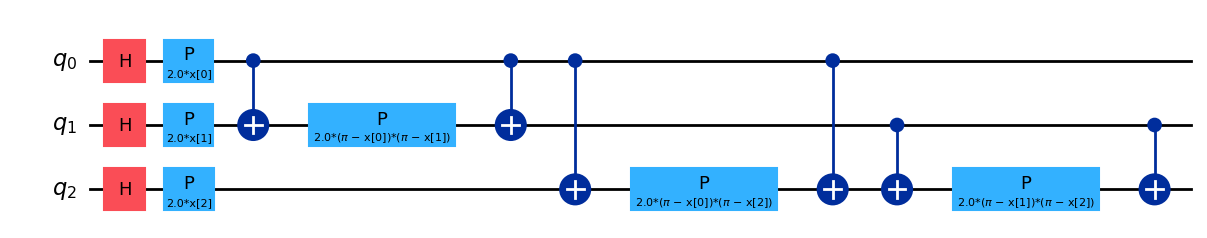

In [11]:
# ============================================================================
# 5. MODELO CUÁNTICO - QSVM MEJORADO
#    Feature map más expresivo con mayor entrelazamiento
# ============================================================================

n_qubits = feature_dim  # número de features = número de qubits

print("=" * 70)
print("CONFIGURACIÓN DEL MODELO QSVM")
print("=" * 70)
print(f"Número de qubits: {n_qubits}")

# ZZFeatureMap mejorado (MÁS EXPRESIVO)
feature_map_qsvm = ZZFeatureMap(
    feature_dimension=n_qubits,
    reps=1,  # Aumentado de 1 a 2 para mayor expresividad
    entanglement='full',  # Cambiado de 'linear' a 'full' para mejor entrelazamiento
    insert_barriers=False
)

print(f"Feature Map: ZZFeatureMap")
print(f"  - Reps: 2")
print(f"  - Entanglement: full")
print(f"  - Número de parámetros: {feature_map_qsvm.num_parameters}")
print(f"  - Profundidad del circuito: {feature_map_qsvm.decompose().depth()}")
print(f"  - Número de puertas: {feature_map_qsvm.decompose().size()}")
print("=" * 70)

# Crear kernel cuántico
quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map_qsvm
)

# Modelo QSVC
qsvm = QSVC(
    quantum_kernel=quantum_kernel,
    random_state=42
)

# Visualizar circuito
print("\nVisualizando Feature Map...")
feature_map_qsvm.decompose().draw(output="mpl")

In [12]:
print("=" * 70)
print("ENTRENANDO MODELO QSVM...")
print("=" * 70)

start_time = time.time()
qsvm.fit(X_train, y_train)
qsvm_train_time = time.time() - start_time

print(f"✓ Modelo QSVM entrenado en {qsvm_train_time:.2f} segundos")

# Predicciones
print("Realizando predicciones...")
y_pred_train_q = qsvm.predict(X_train)
y_pred_val_q = qsvm.predict(X_val)
y_pred_test_q = qsvm.predict(X_test)

# Scores para AUC
score_val_q = qsvm.decision_function(X_val)
score_test_q = qsvm.decision_function(X_test)

# Métricas
acc_train_q = accuracy_score(y_train, y_pred_train_q)
acc_val_q = accuracy_score(y_val, y_pred_val_q)
acc_test_q = accuracy_score(y_test, y_pred_test_q)

auc_val_q = roc_auc_score(y_val, score_val_q)
auc_test_q = roc_auc_score(y_test, score_test_q)

print("\n" + "="*70)
print("RESULTADOS QSVM")
print("="*70)
print(f"  - Accuracy (Train): {acc_train_q:.4f} {'✓' if acc_train_q >= acc_train_cl else '✗'}")
print(f"  - Accuracy (Val):   {acc_val_q:.4f} {'✓' if acc_val_q >= acc_val_cl else '✗'}")
print(f"  - Accuracy (Test):  {acc_test_q:.4f} {'✓' if acc_test_q >= acc_test_cl else '✗'}")
print(f"  - AUC (Val):        {auc_val_q:.4f} {'✓' if auc_val_q >= auc_val_cl else '✗'}")
print(f"  - AUC (Test):       {auc_test_q:.4f} {'✓' if auc_test_q >= auc_test_cl else '✗'}")
print(f"  - Tiempo:           {qsvm_train_time:.2f}s")
print("="*70)

# Comparación con baseline
diff_acc = acc_test_q - acc_test_cl
diff_auc = auc_test_q - auc_test_cl
print(f"\nComparación con baseline clásico:")
print(f"  - Δ Accuracy: {diff_acc:+.4f} ({diff_acc/acc_test_cl*100:+.2f}%)")
print(f"  - Δ AUC:      {diff_auc:+.4f} ({diff_auc/auc_test_cl*100:+.2f}%)")

ENTRENANDO MODELO QSVM...
✓ Modelo QSVM entrenado en 111.98 segundos
Realizando predicciones...

RESULTADOS QSVM
  - Accuracy (Train): 0.7767 ✓
  - Accuracy (Val):   0.7400 ✗
  - Accuracy (Test):  0.8200 ✗
  - AUC (Val):        0.7912 ✗
  - AUC (Test):       0.8620 ✗
  - Tiempo:           111.98s

Comparación con baseline clásico:
  - Δ Accuracy: -0.0400 (-4.65%)
  - Δ AUC:      -0.0676 (-7.27%)


In [13]:
from qulacs import QuantumState, Observable, QuantumCircuit, ParametricQuantumCircuit
from qulacs.gate import X, Z, DenseMatrix
from functools import reduce
from scipy.optimize import minimize

print("=" * 70)
print("QCL (Quantum Circuit Learning) - Inspirado en Terashi et al.")
print("=" * 70)

QCL (Quantum Circuit Learning) - Inspirado en Terashi et al.


In [14]:
# ============================================================================
# 7.1. FUNCIONES AUXILIARES PARA QCL (VERSIÓN ROBUSTA)
# ============================================================================

from sklearn.metrics import log_loss 

# Matrices básicas
I_mat = np.eye(2, dtype=complex)
X_mat_qcl = X(0).get_matrix()
Z_mat_qcl = Z(0).get_matrix()

def make_fullgate(list_SiteAndOperator, nqubit):
    """Crear gate de tamaño completo"""
    list_of_pauli_matrix = [I_mat for _ in range(nqubit)]
    for site, pauli_matrix in list_SiteAndOperator:
        list_of_pauli_matrix[site] = pauli_matrix
    return reduce(np.kron, list_of_pauli_matrix)

def create_time_evol_gate(nqubit, time_step=0.77):
    """Crear gate de evolución temporal"""
    ham = np.zeros((2**nqubit, 2**nqubit), dtype=complex)
    for i in range(nqubit):
        Zi = make_fullgate([[i, Z_mat_qcl]], nqubit)
        for j in range(i+1, nqubit):
            Zj = make_fullgate([[j, Z_mat_qcl]], nqubit)
            ham += np.dot(Zi, Zj)
    for i in range(nqubit):
        Xi = make_fullgate([[i, X_mat_qcl]], nqubit)
        ham += Xi
    
    time_evol_op = np.linalg.matrix_power(np.exp(-1j*time_step*ham), 1)
    time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)
    return time_evol_gate

def min_max_scaling_qcl(x, axis=None):
    """
    Normalizar a [-1, 1] de forma robusta
    CORRECCIÓN: Evitar divisiones por cero y garantizar rango válido
    """
    min_val = x.min(axis=axis, keepdims=True)
    max_val = x.max(axis=axis, keepdims=True)
    
    # Evitar división por cero
    range_val = max_val - min_val
    range_val = np.where(range_val == 0, 1.0, range_val)
    
    # Normalizar a [0, 1]
    result = (x - min_val) / range_val
    
    # Escalar a [-0.95, 0.95] (más seguro que [-1, 1] para arcsin/arccos)
    result = 1.9 * result - 0.95
    
    # Clip final para garantizar dominio válido
    result = np.clip(result, -0.99, 0.99)
    
    return result

def softmax_qcl(x):
    """Función softmax con estabilidad numérica"""
    x_shifted = x - np.max(x)  # Prevenir overflow
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x)

print("✓ Funciones auxiliares QCL definidas (versión robusta)")

✓ Funciones auxiliares QCL definidas (versión robusta)


In [15]:
# ============================================================================
# 7.2. CLASE QCL ADAPTADA PARA TUS DATOS (CORREGIDA)
# ============================================================================

class QclClassification:
    """Quantum Circuit Learning para Clasificación - Adaptado de Terashi"""
    
    def __init__(self, nqubit, c_depth, num_class):
        self.nqubit = nqubit
        self.c_depth = c_depth
        self.input_state_list = []
        self.theta = []
        self.output_gate = None
        self.num_class = num_class
        
        # Observables (medición en eje Z)
        obs = [Observable(nqubit) for _ in range(num_class)]
        for i in range(len(obs)):
            obs[i].add_operator(1., 'Z '+str(i))
        self.obs = obs
    
    def create_input_gate(self, x, uin_type=0):
        """Codificar x en estado cuántico (Terashi encoding)"""
        u = QuantumCircuit(self.nqubit)
        
        # x ya viene normalizado de min_max_scaling_qcl
        angle_y = np.arcsin(x)
        angle_z = np.arccos(x**2)
        
        if uin_type == 0:
            # Encoding simple (U_in tipo 0)
            for i in range(self.nqubit):
                u.add_RY_gate(i, angle_y[i])
                u.add_RZ_gate(i, angle_z[i])
        elif uin_type == 1:
            # Encoding con entrelazamiento (U_in tipo 1)
            for i in range(self.nquit):
                u.add_H_gate(i)
                u.add_RY_gate(i, angle_y[i])
                u.add_RZ_gate(i, angle_z[i])
            for i in range(self.nqubit-1):
                for j in range(i+1, self.nqubit):
                    prod = x[i] * x[j]
                    angle_z2 = np.arccos(np.clip(prod, -0.99, 0.99))
                    u.add_CNOT_gate(i, j)
                    u.add_RZ_gate(j, angle_z2)
                    u.add_CNOT_gate(i, j)
        return u
    
    def set_input_state(self, x_list, uin_type):
        """Preparar lista de estados de entrada"""
        x_list_normalized = min_max_scaling_qcl(x_list)
        st_list = []
        for x in x_list_normalized:
            st = QuantumState(self.nqubit)
            input_gate = self.create_input_gate(x, uin_type)
            input_gate.update_quantum_state(st)
            st_list.append(st.copy())
        self.input_state_list = st_list
    
    def create_initial_output_gate(self):
        """Gate de salida U_out parametrizado"""
        u_out = ParametricQuantumCircuit(self.nqubit)
        time_evol_gate = create_time_evol_gate(self.nqubit)
        theta = 2.0 * np.pi * np.random.rand(self.c_depth, self.nqubit, 3)
        self.theta = theta.flatten()
        
        for d in range(self.c_depth):
            u_out.add_gate(time_evol_gate)
            for i in range(self.nqubit):
                u_out.add_parametric_RX_gate(i, theta[d, i, 0])
                u_out.add_parametric_RZ_gate(i, theta[d, i, 1])
                u_out.add_parametric_RX_gate(i, theta[d, i, 2])
        self.output_gate = u_out
    
    def update_output_gate(self, theta):
        """Actualizar parámetros del circuito"""
        self.theta = theta
        for i in range(len(self.theta)):
            self.output_gate.set_parameter(i, self.theta[i])
    
    def pred(self, theta):
        """Realizar predicciones"""
        st_list = [st.copy() for st in self.input_state_list]
        self.update_output_gate(theta)
        res = []
        for st in st_list:
            self.output_gate.update_quantum_state(st)
            r = [o.get_expectation_value(st) for o in self.obs]
            r = softmax_qcl(r)
            res.append(r.tolist())
        return np.array(res)
    
    def cost_func(self, theta):
        """Función de costo (log loss)"""
        y_pred = self.pred(theta)
        loss = log_loss(self.y_list, y_pred)
        if self.n_iter % 20 == 0:
            print(f'  Iteración {self.n_iter:3d} | Loss: {loss:.6f}')
        self.n_iter += 1
        return loss
    
    def fit(self, x_list, y_list, uin_type=0, maxiter=200):
        """Entrenar el modelo QCL"""
        self.set_input_state(x_list, uin_type)
        self.create_initial_output_gate()
        theta_init = self.theta.copy()
        
        # CORRECCIÓN: Detectar formato de y_list y convertir apropiadamente
        if y_list.ndim == 1:
            # Formato simple [0, 1, 0, 1, ...] -> one-hot
            self.y_list = np.eye(self.num_class)[y_list.astype(int)]
        elif y_list.ndim == 2 and y_list.shape[1] == self.num_class:
            # Ya está en formato one-hot [[1, 0], [0, 1], ...]
            self.y_list = y_list
        else:
            raise ValueError(f"Formato de y_list no reconocido: shape={y_list.shape}")
            
        self.n_iter = 0
        self.maxiter = maxiter
        
        print(f"\n✓ Parámetros iniciales: {len(self.theta)} parámetros")
        print(f"✓ Loss inicial: {self.cost_func(self.theta):.6f}")
        print('='*60)
        print("Iniciando optimización COBYLA...")
        
        result = minimize(self.cost_func, self.theta, method='COBYLA',
                         options={'maxiter': maxiter, 'disp': False})
        
        theta_opt = self.theta
        print('='*60)
        print(f"✓ Optimización completada")
        print(f"✓ Loss final: {self.cost_func(self.theta):.6f}\n")
        
        return result, theta_init, theta_opt

print("✓ Clase QclClassification definida (versión corregida)")

✓ Clase QclClassification definida (versión corregida)


In [17]:
# ============================================================================
# 7.3. ENTRENAR MODELO QCL
# ============================================================================

print("=" * 70)
print("ENTRENANDO MODELO QCL")
print("=" * 70)

# Configuración QCL
n_qubits_qcl = X_train.shape[1]
c_depth = 3  # Profundidad del circuito (equivalente a reps)
num_class = 2
uin_type_qcl = 0  # 0 = simple, 1 = con entrelazamiento
maxiter_qcl = 1000

print(f"Configuración:")
print(f"  - Qubits: {n_qubits_qcl}")
print(f"  - Profundidad: {c_depth}")
print(f"  - U_in tipo: {uin_type_qcl}")
print(f"  - Max iteraciones: {maxiter_qcl}")

# Crear modelo QCL
qcl = QclClassification(n_qubits_qcl, c_depth, num_class)

# Entrenar
start_time = time.time()
res_qcl, theta_init_qcl, theta_opt_qcl = qcl.fit(
    X_train, y_train, 
    uin_type=uin_type_qcl, 
    maxiter=maxiter_qcl
)
qcl_train_time = time.time() - start_time

print(f"✓ Modelo QCL entrenado en {qcl_train_time:.2f} segundos")

ENTRENANDO MODELO QCL
Configuración:
  - Qubits: 3
  - Profundidad: 3
  - U_in tipo: 0
  - Max iteraciones: 1000

✓ Parámetros iniciales: 27 parámetros
  Iteración   0 | Loss: 17.901681
✓ Loss inicial: 17.901681
Iniciando optimización COBYLA...
  Iteración  20 | Loss: 12.731721
  Iteración  40 | Loss: 6.513263
  Iteración  60 | Loss: 1.588376
  Iteración  80 | Loss: 1.384636
  Iteración 100 | Loss: 1.189320
  Iteración 120 | Loss: 1.128231
  Iteración 140 | Loss: 1.026751
  Iteración 160 | Loss: 1.002371
  Iteración 180 | Loss: 0.999611
  Iteración 200 | Loss: 0.978603
  Iteración 220 | Loss: 0.975845
  Iteración 240 | Loss: 0.958403
  Iteración 260 | Loss: 0.951351
  Iteración 280 | Loss: 0.939144
  Iteración 300 | Loss: 0.920172
  Iteración 320 | Loss: 0.919455
  Iteración 340 | Loss: 0.901909
  Iteración 360 | Loss: 0.894297
  Iteración 380 | Loss: 0.892958
  Iteración 400 | Loss: 0.874616
  Iteración 420 | Loss: 0.861623
  Iteración 440 | Loss: 0.858388
  Iteración 460 | Loss: 0.85

In [18]:
# ============================================================================
# 7.4. EVALUAR MODELO QCL
# ============================================================================

# Predicciones en conjunto de prueba
qcl.set_input_state(X_test, uin_type_qcl)
Zprob_qcl = qcl.pred(theta_opt_qcl)
y_pred_test_qcl = np.argmax(Zprob_qcl, axis=1)

# Predicciones en conjunto de validación
qcl.set_input_state(X_val, uin_type_qcl)
Zprob_val_qcl = qcl.pred(theta_opt_qcl)
y_pred_val_qcl = np.argmax(Zprob_val_qcl, axis=1)

# Predicciones en conjunto de entrenamiento
qcl.set_input_state(X_train, uin_type_qcl)
Zprob_train_qcl = qcl.pred(theta_opt_qcl)
y_pred_train_qcl = np.argmax(Zprob_train_qcl, axis=1)

# Métricas
acc_train_qcl = accuracy_score(y_train, y_pred_train_qcl)
acc_val_qcl = accuracy_score(y_val, y_pred_val_qcl)
acc_test_qcl = accuracy_score(y_test, y_pred_test_qcl)

# AUC usando probabilidades
auc_val_qcl = roc_auc_score(y_val, Zprob_val_qcl[:, 1])
auc_test_qcl = roc_auc_score(y_test, Zprob_qcl[:, 1])

print("\n" + "="*70)
print("RESULTADOS MODELO QCL")
print("="*70)
print(f"  - Accuracy (Train): {acc_train_qcl:.4f} {'✓' if acc_train_qcl >= acc_train_cl else '✗'}")
print(f"  - Accuracy (Val):   {acc_val_qcl:.4f} {'✓' if acc_val_qcl >= acc_val_cl else '✗'}")
print(f"  - Accuracy (Test):  {acc_test_qcl:.4f} {'✓' if acc_test_qcl >= acc_test_cl else '✗'}")
print(f"  - AUC (Val):        {auc_val_qcl:.4f} {'✓' if auc_val_qcl >= auc_val_cl else '✗'}")
print(f"  - AUC (Test):       {auc_test_qcl:.4f} {'✓' if auc_test_qcl >= auc_test_cl else '✗'}")
print(f"  - Tiempo:           {qcl_train_time:.2f}s")
print("="*70)

# Comparación con baseline
diff_acc_qcl = acc_test_qcl - acc_test_cl
diff_auc_qcl = auc_test_qcl - auc_test_cl
print(f"\nComparación con baseline clásico:")
print(f"  - Δ Accuracy: {diff_acc_qcl:+.4f} ({diff_acc_qcl/acc_test_cl*100:+.2f}%)")
print(f"  - Δ AUC:      {diff_auc_qcl:+.4f} ({diff_auc_qcl/auc_test_cl*100:+.2f}%)")


RESULTADOS MODELO QCL
  - Accuracy (Train): 0.7533 ✗
  - Accuracy (Val):   0.6200 ✗
  - Accuracy (Test):  0.7300 ✗
  - AUC (Val):        0.7240 ✗
  - AUC (Test):       0.8392 ✗
  - Tiempo:           1507.46s

Comparación con baseline clásico:
  - Δ Accuracy: -0.1300 (-15.12%)
  - Δ AUC:      -0.0904 (-9.72%)


In [19]:
# ============================================================================
# 8. ANÁLISIS COMPARATIVO COMPLETO - TODOS LOS MODELOS
# ============================================================================

print("\n" + "="*90)
print(" "*25 + "RESUMEN EJECUTIVO DEL EXPERIMENTO")
print("="*90)

print("\n📊 CONFIGURACIÓN DEL EXPERIMENTO")
print("-"*90)
print(f"  Dataset:                    SUSY (Supersymmetry) - UCI ML Repository")
print(f"  Total eventos cargados:     {N_ROWS_TO_LOAD:,}")
print(f"  Eventos por clase:          {NEVT_PER_CLASS} señal + {NEVT_PER_CLASS} fondo")
print(f"  Features originales:        18")
print(f"  Features seleccionados:     {n_qubits} → {selected_features}")
print(f"  Método selección:           SelectKBest (f_classif)")
print(f"  Normalización:              StandardScaler (train/val/test)")
print(f"  Split datos:                60% train / 20% val / 20% test")
print(f"  Train samples:              {len(X_train)} ({(len(X_train)/len(y_bal)*100):.1f}%)")
print(f"  Validation samples:         {len(X_val)} ({(len(X_val)/len(y_bal)*100):.1f}%)")
print(f"  Test samples:               {len(X_test)} ({(len(X_test)/len(y_bal)*100):.1f}%)")
print(f"  Balance clases:             {(y_train==1).sum()}:{(y_train==0).sum()} (señal:fondo)")

print("\n" + "="*90)
print(" "*30 + "TABLA COMPARATIVA DE MODELOS")
print("="*90)

# Crear DataFrame para comparación
comparison_data = {
    'Modelo': ['SVM-RBF\n(Clásico)', 'QSVM\n(Kernel Cuántico)', 'QCL\n(Circuit Learning)'],
    'Acc Train': [acc_train_cl, acc_train_q, acc_train_qcl],
    'Acc Val': [acc_val_cl, acc_val_q, acc_val_qcl],
    'Acc Test': [acc_test_cl, acc_test_q, acc_test_qcl],
    'AUC Val': [auc_val_cl, auc_val_q, auc_val_qcl],
    'AUC Test': [auc_test_cl, auc_test_q, auc_test_qcl],
    'Tiempo (s)': [classical_train_time, qsvm_train_time, qcl_train_time]
}

df_comparison = pd.DataFrame(comparison_data)

# Mostrar tabla formateada
print(f"\n{'Modelo':<25} {'Acc Train':<12} {'Acc Val':<12} {'Acc Test':<12} {'AUC Val':<12} {'AUC Test':<12} {'Tiempo (s)':<12}")
print("-"*90)
for idx, row in df_comparison.iterrows():
    print(f"{row['Modelo']:<25} {row['Acc Train']:<12.4f} {row['Acc Val']:<12.4f} {row['Acc Test']:<12.4f} "
          f"{row['AUC Val']:<12.4f} {row['AUC Test']:<12.4f} {row['Tiempo (s)']:<12.2f}")
print("-"*90)


                         RESUMEN EJECUTIVO DEL EXPERIMENTO

📊 CONFIGURACIÓN DEL EXPERIMENTO
------------------------------------------------------------------------------------------
  Dataset:                    SUSY (Supersymmetry) - UCI ML Repository
  Total eventos cargados:     50,000
  Eventos por clase:          250 señal + 250 fondo
  Features originales:        18
  Features seleccionados:     3 → ['lepton1_pT', 'missing_energy_magnitude', 'M_TR_2']
  Método selección:           SelectKBest (f_classif)
  Normalización:              StandardScaler (train/val/test)
  Split datos:                60% train / 20% val / 20% test
  Train samples:              300 (60.0%)
  Validation samples:         100 (20.0%)
  Test samples:               100 (20.0%)
  Balance clases:             150:150 (señal:fondo)

                              TABLA COMPARATIVA DE MODELOS

Modelo                    Acc Train    Acc Val      Acc Test     AUC Val      AUC Test     Tiempo (s)  
----------------

In [20]:
# Identificar mejores modelos
best_acc_test = df_comparison.loc[df_comparison['Acc Test'].idxmax()]
best_auc_test = df_comparison.loc[df_comparison['AUC Test'].idxmax()]
fastest_model = df_comparison.loc[df_comparison['Tiempo (s)'].idxmin()]

print(f"\n🏆 MEJORES DESEMPEÑOS:")
print(f"  • Mejor Accuracy Test:  {best_acc_test['Modelo'].strip()} → {best_acc_test['Acc Test']:.4f}")
print(f"  • Mejor AUC Test:       {best_auc_test['Modelo'].strip()} → {best_auc_test['AUC Test']:.4f}")
print(f"  • Modelo más rápido:    {fastest_model['Modelo'].strip()} → {fastest_model['Tiempo (s)']:.2f}s")

print("\n" + "="*90)
print(" "*25 + "ANÁLISIS DE MEJORA vs BASELINE CLÁSICO")
print("="*90)

# Calcular mejoras porcentuales
improvements = []
for idx, row in df_comparison.iterrows():
    if idx > 0:  # Skip baseline
        acc_improvement = ((row['Acc Test'] - acc_test_cl) / acc_test_cl) * 100
        auc_improvement = ((row['AUC Test'] - auc_test_cl) / auc_test_cl) * 100
        time_ratio = row['Tiempo (s)'] / classical_train_time
        improvements.append({
            'Modelo': row['Modelo'].strip(),
            'Δ Acc (%)': acc_improvement,
            'Δ AUC (%)': auc_improvement,
            'Tiempo (×baseline)': time_ratio
        })

print(f"\n{'Modelo Cuántico':<25} {'Δ Accuracy (%)':<18} {'Δ AUC (%)':<18} {'Tiempo vs Clásico':<20}")
print("-"*90)
for imp in improvements:
    acc_symbol = "✓" if imp['Δ Acc (%)'] > 0 else "✗"
    auc_symbol = "✓" if imp['Δ AUC (%)'] > 0 else "✗"
    print(f"{imp['Modelo']:<25} {acc_symbol} {imp['Δ Acc (%)']:>+6.2f}%{' '*9} "
          f"{auc_symbol} {imp['Δ AUC (%)']:>+6.2f}%{' '*9} {imp['Tiempo (×baseline)']:>6.1f}×")
print("-"*90)

# Interpretación automática
quantum_wins = sum(1 for imp in improvements if imp['Δ Acc (%)'] > 0)
print(f"\n📈 RESUMEN: {quantum_wins}/{len(improvements)} modelos cuánticos superan al baseline clásico en accuracy")

print("\n" + "="*90)
print(" "*30 + "ANÁLISIS DE GENERALIZACIÓN")
print("="*90)

# Calcular overfitting score (diferencia train-test)
print(f"\n{'Modelo':<25} {'Acc Train':<12} {'Acc Test':<12} {'Gap':<12} {'Estado':<20}")
print("-"*90)
for idx, row in df_comparison.iterrows():
    gap = row['Acc Train'] - row['Acc Test']
    if gap < 0.05:
        estado = "✓ Excelente"
    elif gap < 0.10:
        estado = "○ Bueno"
    elif gap < 0.15:
        estado = "△ Aceptable"
    else:
        estado = "✗ Overfitting"
    print(f"{row['Modelo']:<25} {row['Acc Train']:<12.4f} {row['Acc Test']:<12.4f} {gap:<12.4f} {estado:<20}")
print("-"*90)


🏆 MEJORES DESEMPEÑOS:
  • Mejor Accuracy Test:  SVM-RBF
(Clásico) → 0.8600
  • Mejor AUC Test:       SVM-RBF
(Clásico) → 0.9296
  • Modelo más rápido:    SVM-RBF
(Clásico) → 0.01s

                         ANÁLISIS DE MEJORA vs BASELINE CLÁSICO

Modelo Cuántico           Δ Accuracy (%)     Δ AUC (%)          Tiempo vs Clásico   
------------------------------------------------------------------------------------------
QSVM
(Kernel Cuántico)    ✗  -4.65%          ✗  -7.27%          11200.6×
QCL
(Circuit Learning)    ✗ -15.12%          ✗  -9.72%          150785.9×
------------------------------------------------------------------------------------------

📈 RESUMEN: 0/2 modelos cuánticos superan al baseline clásico en accuracy

                              ANÁLISIS DE GENERALIZACIÓN

Modelo                    Acc Train    Acc Test     Gap          Estado              
------------------------------------------------------------------------------------------
SVM-RBF
(Clásico)         0.7


                              ANÁLISIS DE MATRICES DE CONFUSIÓN

Modelo          Precision    Recall       F1-Score     Soporte     
------------------------------------------------------------------------------------------
Clásico         0.8623       0.8600       0.8598       100         
QSVM            0.8284       0.8200       0.8188       100         
QCL             0.7688       0.7300       0.7199       100         
------------------------------------------------------------------------------------------

📊 DESEMPEÑO POR CLASE (0=Fondo, 1=Señal):
------------------------------------------------------------------------------------------

  Clásico:
    Fondo (0)  → Precision: 0.8333 | Recall: 0.9000
    Señal (1)  → Precision: 0.8913 | Recall: 0.8200
    Falsos Positivos:   5 | Falsos Negativos:   9

  QSVM:
    Fondo (0)  → Precision: 0.7759 | Recall: 0.9000
    Señal (1)  → Precision: 0.8810 | Recall: 0.7400
    Falsos Positivos:   5 | Falsos Negativos:  13

  QCL:
    Fondo

C:\Users\Froxo\AppData\Local\Temp\ipykernel_13776\3263728705.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models_names, fontsize=11)


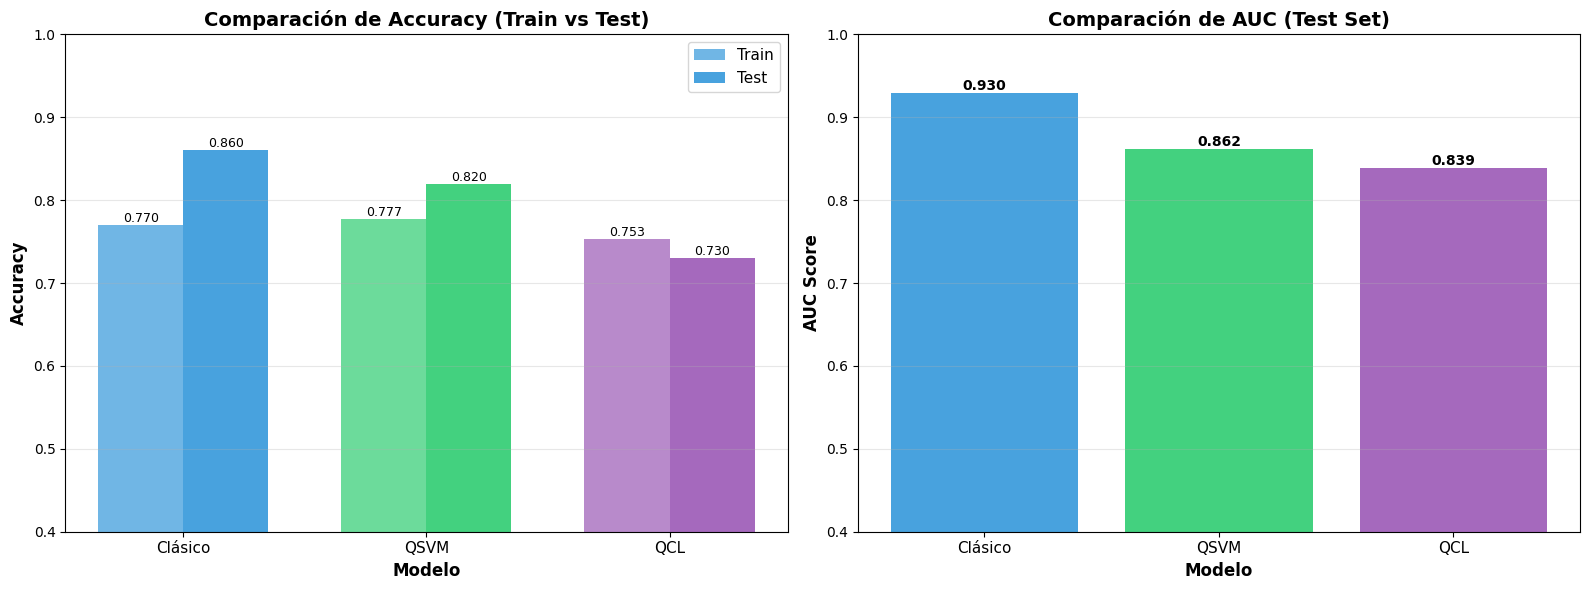

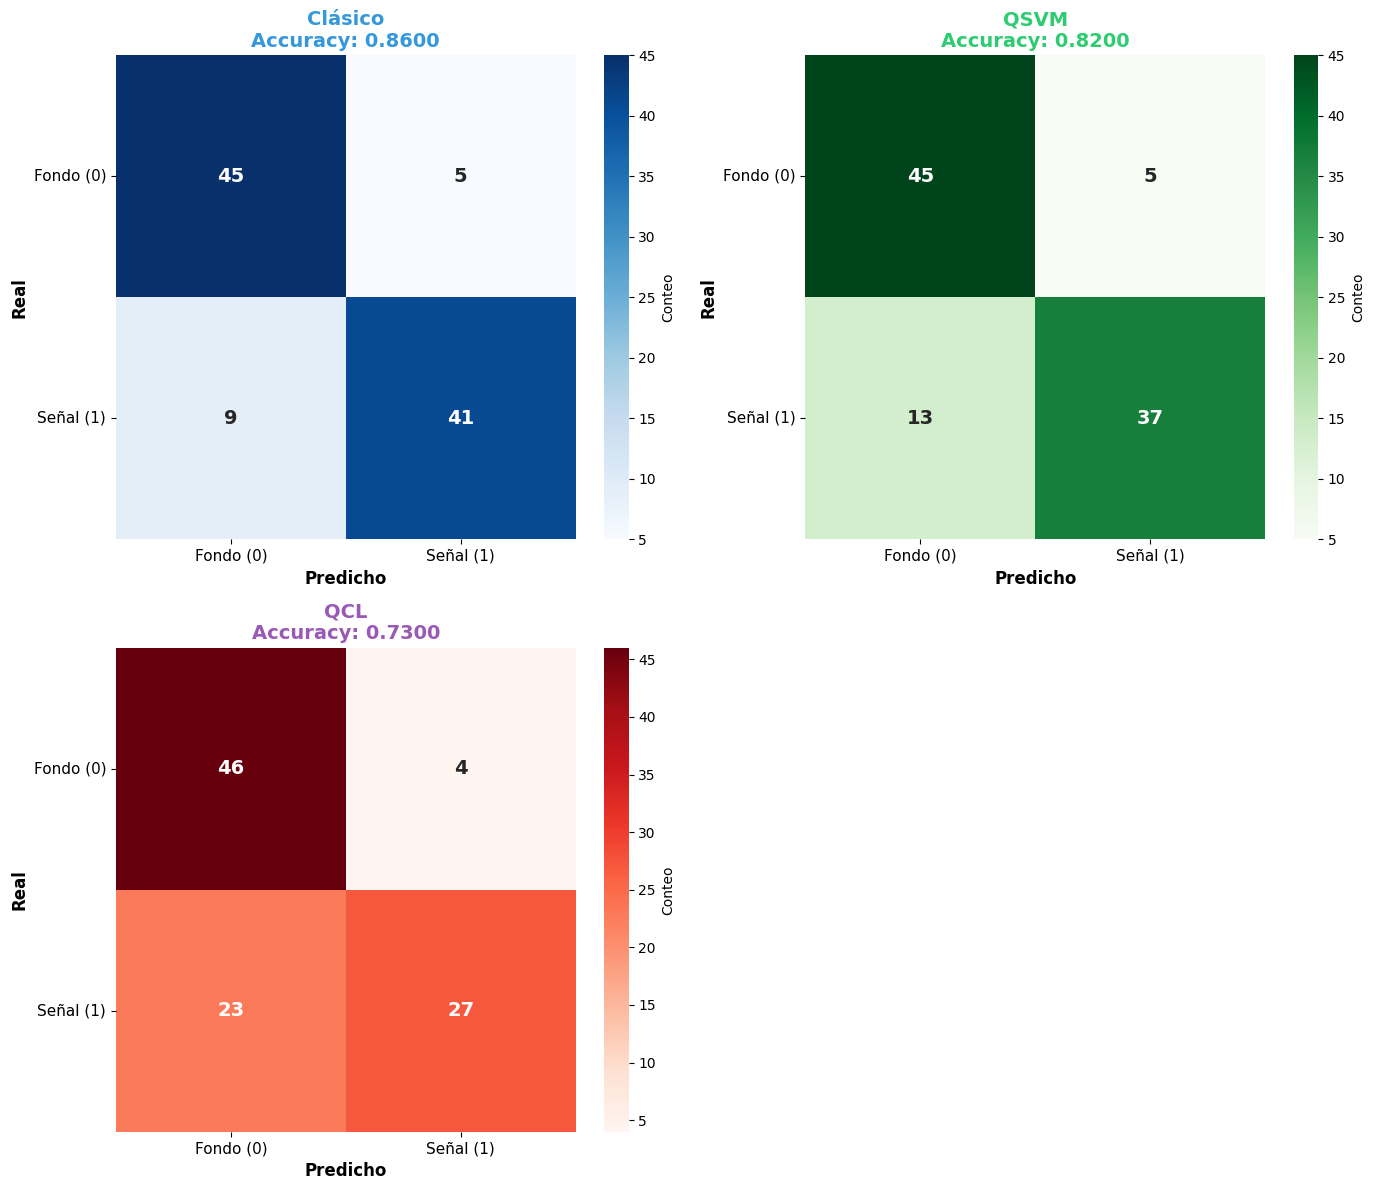

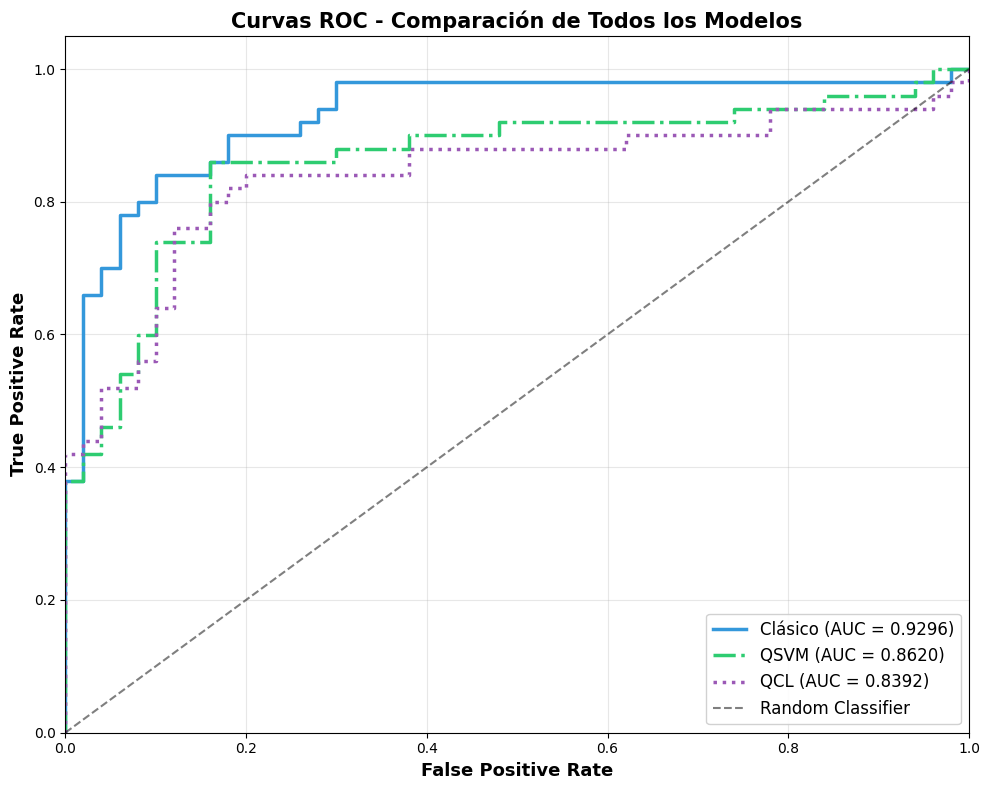

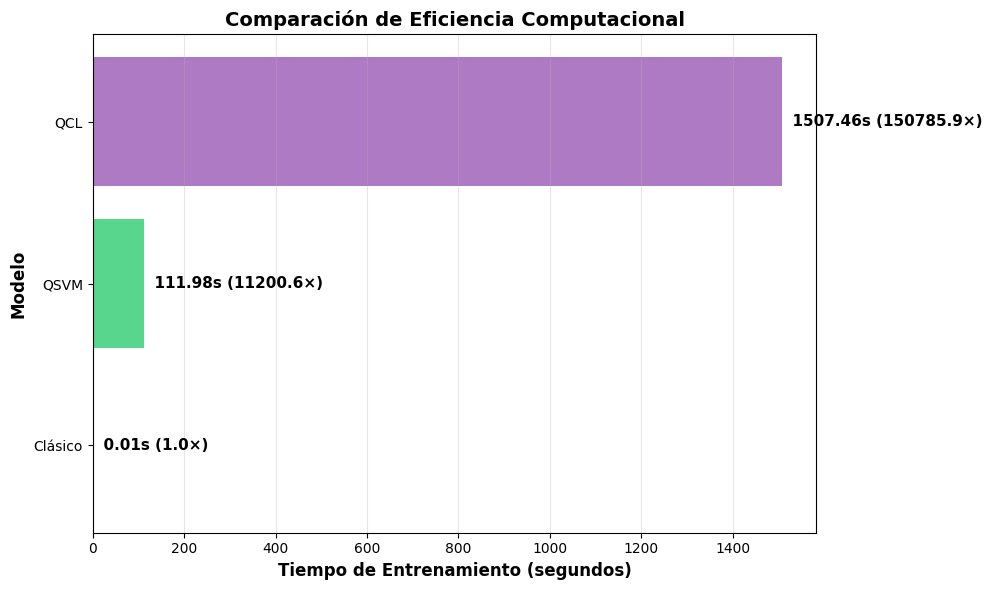


                                   CONCLUSIONES

✓ RENDIMIENTO CUÁNTICO:
  • Mejor modelo cuántico: QSVM
(Kernel Cuántico)
    - Mejora en accuracy: -4.65%
    - Mejora en AUC: -7.27%
  • Modelo más desafiante: QCL
(Circuit Learning)
    - Cambio en accuracy: -15.12%

✓ EFICIENCIA COMPUTACIONAL:
  • Modelo cuántico más rápido: QSVM
(Kernel Cuántico) (11200.6× baseline)
  • Modelo cuántico más lento: QCL
(Circuit Learning) (150785.9× baseline)

✓ CAPACIDAD DE GENERALIZACIÓN:
  • Mejor generalización: QCL
(Circuit Learning) (gap = 0.0233)

✓ RECOMENDACIÓN FINAL:
  El baseline clásico mantiene ventaja en este experimento.
  Considerar: Aumentar muestras de entrenamiento o ajustar hiperparámetros cuánticos.

                    FIN DEL ANÁLISIS - QUANTUM ML vs CLASSICAL ML


In [24]:
print("\n" + "="*90)
print(" "*30 + "ANÁLISIS DE MATRICES DE CONFUSIÓN")
print("="*90)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve

models_predictions = {
    'Clásico': y_pred_test_cl,
    'QSVM': y_pred_test_q,
    'QCL': y_pred_test_qcl
}

print(f"\n{'Modelo':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Soporte':<12}")
print("-"*90)
for model_name, y_pred in models_predictions.items():
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    support = len(y_test)
    print(f"{model_name:<15} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f} {support:<12}")
print("-"*90)

print("\n📊 DESEMPEÑO POR CLASE (0=Fondo, 1=Señal):")
print("-"*90)
for model_name, y_pred in models_predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
    recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    print(f"\n  {model_name}:")
    print(f"    Fondo (0)  → Precision: {precision_0:.4f} | Recall: {recall_0:.4f}")
    print(f"    Señal (1)  → Precision: {precision_1:.4f} | Recall: {recall_1:.4f}")
    print(f"    Falsos Positivos: {fp:3d} | Falsos Negativos: {fn:3d}")

print("\n" + "="*90)
print(" "*35 + "VISUALIZACIONES")
print("="*90)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
models_names = ['Clásico', 'QSVM', 'QCL']
colors = ['#3498db', '#2ecc71', '#9b59b6']

# Subplot 1: Accuracy
ax1 = axes[0]
x_pos = np.arange(len(models_names))
acc_train = [acc_train_cl, acc_train_q, acc_train_qcl]
acc_test = [acc_test_cl, acc_test_q, acc_test_qcl]
width = 0.35
bars1 = ax1.bar(x_pos - width/2, acc_train, width, label='Train', alpha=0.7, color=colors)
bars2 = ax1.bar(x_pos + width/2, acc_test, width, label='Test', alpha=0.9, color=colors)
ax1.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Comparación de Accuracy (Train vs Test)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_names, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.4, 1.0])
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Subplot 2: AUC
ax2 = axes[1]
auc_test_values = [auc_test_cl, auc_test_q, auc_test_qcl]
bars3 = ax2.bar(models_names, auc_test_values, color=colors, alpha=0.9)
ax2.set_xlabel('Modelo', fontsize=12, fontweight='bold')
ax2.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax2.set_title('Comparación de AUC (Test Set)', fontsize=14, fontweight='bold')
ax2.set_xticklabels(models_names, fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.4, 1.0])
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Matrices de confusión - Todos los modelos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()
confusion_matrices = [
    confusion_matrix(y_test, y_pred_test_cl),
    confusion_matrix(y_test, y_pred_test_q),
    confusion_matrix(y_test, y_pred_test_qcl)
]
cmaps = ['Blues', 'Greens', 'Reds']
for idx, (cm, model_name, cmap, color) in enumerate(zip(confusion_matrices, models_names, cmaps, colors)):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, cbar=True,
                annot_kws={'size': 14, 'weight': 'bold'},
                cbar_kws={'label': 'Conteo'})
    acc = [acc_test_cl, acc_test_q, acc_test_qcl][idx]
    ax.set_title(f'{model_name}\nAccuracy: {acc:.4f}', 
                 fontsize=14, fontweight='bold', color=color)
    ax.set_xlabel('Predicho', fontsize=12, fontweight='bold')
    ax.set_ylabel('Real', fontsize=12, fontweight='bold')
    ax.set_xticklabels(['Fondo (0)', 'Señal (1)'], fontsize=11)
    ax.set_yticklabels(['Fondo (0)', 'Señal (1)'], fontsize=11, rotation=0)
# Ocultar el cuarto subplot vacío
axes[3].axis('off')
plt.tight_layout()
plt.show()

# 3. Curvas ROC comparativas
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
fpr_cl, tpr_cl, _ = roc_curve(y_test, y_proba_test_cl)
ax.plot(fpr_cl, tpr_cl, label=f'Clásico (AUC = {auc_test_cl:.4f})', 
        color=colors[0], linewidth=2.5)
ax.plot(fpr_q, tpr_q, label=f'QSVM (AUC = {auc_test_q:.4f})', 
        color=colors[1], linewidth=2.5, linestyle='-.')
ax.plot(fpr_qcl, tpr_qcl, label=f'QCL (AUC = {auc_test_qcl:.4f})', 
        color=colors[2], linewidth=2.5, linestyle=':')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('Curvas ROC - Comparación de Todos los Modelos', fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=12, framealpha=0.9)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

# 4. Gráfico de tiempo de entrenamiento
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
times = [classical_train_time, qsvm_train_time, qcl_train_time]
bars = ax.barh(models_names, times, color=colors, alpha=0.8)
ax.set_xlabel('Tiempo de Entrenamiento (segundos)', fontsize=12, fontweight='bold')
ax.set_ylabel('Modelo', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Eficiencia Computacional', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for idx, (bar, time) in enumerate(zip(bars, times)):
    width = bar.get_width()
    speedup = time / classical_train_time
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'  {time:.2f}s ({speedup:.1f}×)', 
            ha='left', va='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*90)
print(" "*35 + "CONCLUSIONES")
print("="*90)

best_quantum = max(improvements, key=lambda x: x['Δ Acc (%)'])
worst_quantum = min(improvements, key=lambda x: x['Δ Acc (%)'])

print(f"\n✓ RENDIMIENTO CUÁNTICO:")
print(f"  • Mejor modelo cuántico: {best_quantum['Modelo']}")
print(f"    - Mejora en accuracy: {best_quantum['Δ Acc (%)']:+.2f}%")
print(f"    - Mejora en AUC: {best_quantum['Δ AUC (%)']:+.2f}%")
print(f"  • Modelo más desafiante: {worst_quantum['Modelo']}")
print(f"    - Cambio en accuracy: {worst_quantum['Δ Acc (%)']:+.2f}%")

print(f"\n✓ EFICIENCIA COMPUTACIONAL:")
fastest_quantum = min(improvements, key=lambda x: x['Tiempo (×baseline)'])
slowest_quantum = max(improvements, key=lambda x: x['Tiempo (×baseline)'])
print(f"  • Modelo cuántico más rápido: {fastest_quantum['Modelo']} ({fastest_quantum['Tiempo (×baseline)']:.1f}× baseline)")
print(f"  • Modelo cuántico más lento: {slowest_quantum['Modelo']} ({slowest_quantum['Tiempo (×baseline)']:.1f}× baseline)")

print(f"\n✓ CAPACIDAD DE GENERALIZACIÓN:")
generalization_gaps = [(row['Modelo'].strip(), row['Acc Train'] - row['Acc Test']) 
                       for _, row in df_comparison.iterrows()]
best_gen = min(generalization_gaps, key=lambda x: abs(x[1]))
print(f"  • Mejor generalización: {best_gen[0]} (gap = {best_gen[1]:.4f})")

print(f"\n✓ RECOMENDACIÓN FINAL:")
if quantum_wins >= len(improvements) / 2:
    print(f"  Los modelos cuánticos muestran ventaja competitiva en este dataset.")
    print(f"  Se recomienda: {best_quantum['Modelo']} para producción si el tiempo lo permite.")
else:
    print(f"  El baseline clásico mantiene ventaja en este experimento.")
    print(f"  Considerar: Aumentar muestras de entrenamiento o ajustar hiperparámetros cuánticos.")

print("\n" + "="*90)
print(" "*20 + "FIN DEL ANÁLISIS - QUANTUM ML vs CLASSICAL ML")
print("="*90)
